# EPITA 2023 MLRF practice_02-01_detection-description v2023-05-22_163114 by Joseph CHAZALON

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Practice 02 part 01: Keypoint detection and description
Our goal here is to build a framework which will compare pre-selected bubbles (using color histograms) in a way more robust than template matching (which is skipped this year).

The issue with template matching is that we need to slide the template over the test image, eventually producing supurious correlations (over flat regions for instance).
![template matching](img/template-matching.jpg)

What we will do instead is to find stable points within texture patterns, and compare the region centered around those points.
![poi matching](img/poi-matching.jpg)


This part contains the following steps:
1. Manually detect Harris corners.
2. Extract descriptors around those keypoints.
3. Precompute the keypoints and their descriptors for all bubbles.

## 1. Harris corner detector
We will implement a Harris corner detector now.

### 1.1. Mathematical background and how we derive what we will compute 

#### The basic idea
A corner is an image patch which exhibits a high difference with itself when translated in any direction, ie where
$$(I(x+\Delta_x,y+\Delta_y) - I(x,y))^2$$
is high, $(\Delta_x,\Delta_y)$ being a displacement vector.

#### Practical consideration
In practice we pool the previous indicator function over a small region $R = [-s,s] \times [-s,s]$ and 
we use a weighting function $w(u,v)$ (with $(u,v) \in R$) to weight the contribution of each displacement to the global sum:
$$
S(x,y) = \sum_u \sum_v w(u,v) \, \left( I(x+u+\Delta_x,y+v+\Delta_y) - I(x+u,y+v)\right)^2
$$
where $u$ and $v$ both take values in $[-s,+s]$ if $s$ is the size of the neighborhood we consider.
Usually $w(u,v)$ is either a [box filter](https://en.wikipedia.org/wiki/Box_blur) or a [Gaussian](https://en.wikipedia.org/wiki/Gaussian_function).

#### Computation trick using precomputed derivatives
$I(x+\Delta_x,y+\Delta_y)$ can be approximated by a [Taylor expansion](https://en.wikipedia.org/wiki/Taylor_series):
$$
I(x+\Delta_x,y+\Delta_y) \approx I(x,y) + \Delta_x \frac{\partial I(x,y)}{\partial x} + \Delta_y \frac{\partial I(x,y)}{\partial y} + \cdots
$$
This allows us to "simplify" the original equation, and more important making it faster to compute, thanks to simpler derivatives which can be computed for the whole image:
$$
S(x,y) \approx \sum_u \sum_v w(u,v) \left( \Delta_x \frac{\partial I(x+u,y+v)}{\partial x} + \Delta_y \frac{\partial I(x+u,y+v)}{\partial y} \right)^2
$$
which can be rewritten as:
$$
S(x,y) \approx \sum_u \sum_v w(u,v) \left( (\Delta_x \frac{\partial I(x+u,y+v)}{\partial x})^2 + (\Delta_y \frac{\partial I(x+u,y+v)}{\partial y})^2 + 2 \Delta_x \Delta_y \frac{\partial I(x+u,y+v)}{\partial x} \frac{\partial I(x+u,y+v)}{\partial y} \right)
$$
or, using the matrix form which is usually given:
$$
S(x,y) \approx \begin{pmatrix} \Delta_x & \Delta_y \end{pmatrix} A(x,y) \begin{pmatrix} \Delta_x \\ \Delta_y \end{pmatrix},
$$
where $A(x,y)$ is the [structure tensor](https://en.wikipedia.org/wiki/Structure_tensor):
$$
A = \sum_u \sum_v w(u,v) 
\begin{bmatrix}
\frac{\partial I^2(x+u,y+v)}{\partial x} & \frac{\partial I(x+u,y+v)}{\partial x} \frac{\partial I(x+u,y+v)}{\partial y} \\
\frac{\partial I(x+u,y+v)}{\partial x} \frac{\partial I(x+u,y+v)}{\partial y} & \frac{\partial I^2(x+u,y+v)}{\partial y} 
\end{bmatrix}
=
\begin{bmatrix}
\langle I_x^2 \rangle & \langle I_x I_y \rangle\\
\langle I_x I_y \rangle & \langle I_y^2 \rangle
\end{bmatrix}
$$
where:
- $\langle \cdots \rangle$ denotes the windowed summation over $R$;
- $I_x$ is the $x$ derivative of $I$;
- $I_y$ is the $y$ derivative of $I$.

This trick is useful because $I_x$ and $I_y$ can be precomputed very simply.

#### Identifying corners
A corner (or in general an interest point) is characterized by a large variation of $S$ in all directions of the vector $\begin{pmatrix} x & y \end{pmatrix}$.  By analyzing the eigenvalues of $A$, this characterization can be expressed in the following way: $A$ should have two "large" eigenvalues for an interest point.
Based on the magnitudes of the eigenvalues, the following inferences can be made based on this argument:
- If $\lambda_1 \approx 0$ and $\lambda_2 \approx 0$ then this pixel $(x,y)$ has no features of interest.
- If $\lambda_1 \approx 0$ and $\lambda_2$ has some large positive value, then an edge is found.
- If $ \lambda_1$ and $ \lambda_2$ have large positive values, then a corner is found.

To avoid the computation of the eigenvalues, which used to be expensive, Harris and Stephens instead suggest the
following function $M_c$, where $\kappa$ is a tunable sensitivity parameter:

$$
M_c = \lambda_1 \lambda_2 - \kappa \, (\lambda_1 + \lambda_2)^2
= \operatorname{det}(A) - \kappa \, \operatorname{trace}^2(A)
$$

Or, if we prefer to avoid setting the parameter $\kappa$, we can use Noble's corner measure $M_c'$ which amounts to the harmonic mean of the eigenvalues:
$$
M_c' = 2 \frac{\operatorname{det}(A)}{\operatorname{trace}(A) + \epsilon},
$$
$\epsilon$ being a small positive constant.


$A$ being a 2x2 matrix, we have the following relations:
- $\operatorname{det}(A) = A_{1,1} A_{2,2} - A_{2,1} A_{1,2}$
- $\operatorname{trace}(A) = A_{1,1} + A_{2,2}$

Using previous definitions, we obtain:
- $\operatorname{det}(A) = \langle I_x^2 \rangle \langle I_y^2 \rangle - \langle I_x I_y \rangle^2$
- $\operatorname{trace}(A) = \langle I_x^2 \rangle + \langle I_y^2 \rangle$

![](img/stop.png)

#### Computing $I_x$ and $I_y$ in practice
A naive way of computing an approximation of $I_x$ (resp. $I_y$) would be to simply compute the difference between pixel value in horizontal (resp. vertical) directions. `np.gradient` would then compute something like:
$$I_x(x,y) = I(x,y) - I(x+1,y),$$
which produces **spiky results** and lead to **poor performance**.

So, in practice we **smooth the image before computing the gradients**.
A common practice is to perform a small Gaussian blur before applying the Sobel operator in both directions, but we can be even more efficient by convolving our image with $G_x$ and $G_y$, two Gaussian derivative kernels with respect to $x$ and $y$!

We can relate that to algebraic properties of convolutions:

$$\begin{array}{l}
\textrm{Derivative}_x * \textrm{Gaussian} * \textrm{Image} &= \textrm{Gaussian} * \textrm{Derivative}_x * \textrm{Image}\\
&= (\textrm{Gaussian} * \textrm{Derivative}_x) * \textrm{Image}\\
&= (\textrm{Sobel}_x) * \textrm{Image}
\end{array}$$


**So, to compute $I_x$ or $I_y$, one only needs to convolve $I$ with a Gaussian derivative kernel with respect to $x$ or $y$.**

#### Harris response, to sum up
**In summary, given an image, we can compute the Harris corner response image by simply computing:**
- **$I_x$: $I$'s smoothed (interpolated) partial derivative with respect to $x$;**
- **$I_y$: $I$'s smoothed (interpolated) partial derivative with respect to $y$;**
- **$\langle I_x^2 \rangle$: the windowed sum of $I^2_x$;**
- **$\langle I_y^2 \rangle$: the windowed sum of $I^2_y$;**
- **$\langle I_x I_y \rangle$: the windowed sum of $I_x I_y$;**
- **$\operatorname{det}(A)$;**
- **$\operatorname{trace}(A)$;**
- **$M_c'' = \frac{\operatorname{det}(A)}{\operatorname{trace}(A) + \epsilon}$.**

### 1.2. Implement the computation of the Harris response
Enough math, let's code!
We will guide you along the process, so be reassured.

After some setup, we will implement the computation of the response image progressively.

In [2]:
# deactivate buggy jupyter completion
%config Completer.use_jedi = False

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
#%matplotlib inline
import os

In [5]:
# TODO
PATH_TO_RESOURCES = "./img/"  # FIXME set this to the path of the twinit resource directory

#### 1.2.1 Gaussian and Gaussian derivatives
A [Gaussian function](https://en.wikipedia.org/wiki/Gaussian_function) is a function of the form:
$$
f(x) = a e^{-(x-b)^2/(2c^2)}
$$
The graph of a Gaussian is a characteristic symmetric "[bell curve](https://en.wikipedia.org/wiki/Normal_distribution)" shape.
The parameter $a$ is the height of the curve's peak, $b$ is the position of the center of the peak and $c$ (the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation)) controls the width of the "bell".

In our case, we have a two-dimensional signal therefore our function has the form:
$$f(x,y) = a \exp\left(- \left(\frac{(x-x_o)^2}{2\sigma_X^2} + \frac{(y-y_o)^2}{2\sigma_Y^2} \right)\right).$$

Here the coefficient $a$ is the amplitude, $x_0,y_0$ is the center and $\sigma_x,\sigma_y$ are the $x$ and $y$ spreads of the blob.

In our case, we will define our Gaussian kernel with respect to the size $s$ of the window $w$.
We want to have:
- an amplitude ($a$) of $1$;
- a center $x_0,y_0$ at the middle of the window: $(0,0)$;
- a spread $\sigma_x,\sigma_y$ of one third of the size of the window: $(s/3,s/3)$.

The derivatives are easy to compute in our case.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Complete the function below to generate a Gaussian kernel.**

Tips:
- Do no worry about scaling factors for kernels as they will be scaled automatically during the convolution process.
- Make sure to check the documentation of [`np.mgrid`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mgrid.html) which generates a grid of coordinates.
</div>

In [6]:
# Run me!
np.mgrid[-1:1+1,-1:1+1]

array([[[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]],

       [[-1,  0,  1],
        [-1,  0,  1],
        [-1,  0,  1]]])

Tip: you have to implement this:

$$g(x,y) = \exp\left(- \left(\frac{(x)^2}{2\sigma_X^2} + \frac{(y)^2}{2\sigma_Y^2} \right)\right)$$

with 
$$\sigma_X = \sigma_Y = \frac{1}{3} \text{size}$$

In [30]:
# TODO complete the code of this function
def gauss_kernel(size: int) -> np.array:
    """
    Returns a 2D Gaussian kernel for convolutions.
    
    Parameters
    ----------
    size: int
        Size of the kernel to build
    
    Returns
    -------
    kernel: np.array of shape (size, size) and dtype np.float32
        Resulting Gaussian kernel where kernel[i,j] = Gaussian(i, j, mu=(0,0), sigma=(size/3, size/3))
    """
    size = int(size)
    y, x = np.mgrid[-size:size+1, -size:size+1]

    # x and y coefficients of a 2D gaussian with standard dev half of size
    # (ignore scale factor)
    
    # FIXME this is a box filter, adapt it to be a Gaussian
    sigma = (1 / 3) * size 
    g = np.exp(-((x**2 / (2 * sigma**2)) + (y**2 / (2 * sigma**2))))
    # (this would also work, but would lead to poorer performance)
    #g = np.ones((size*2+1, size*2+1))
    
    return g

Let us quickly display this kernel to check its shape.
We are looking for something which looks like this, ie a maximal response at the center of the window, then a smooth decrease toward the borders of the window where we have values close to 0:
![Gaussian](img/gaussian_example.png)

In [31]:
# Run this cell
from mpl_toolkits.mplot3d import Axes3D

(11, 11) (11, 11) (11, 11)


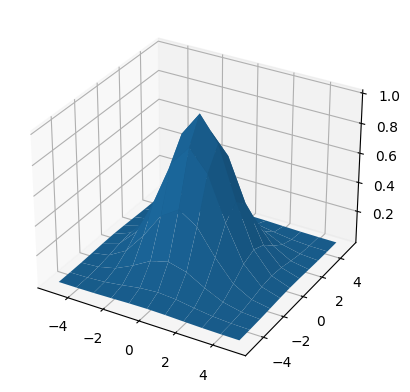

In [32]:
# Run this cell
wsize = 5
Y,X = np.mgrid[-wsize:wsize+1,-wsize:wsize+1]
Z = gauss_kernel(wsize)
print(X.shape, Y.shape, Z.shape)
# print(Z)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z);

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Complete the function below to generate two Gaussian derivative kernels, then plot them.**

Tips:
- Do no worry about scaling factors for kernels as they will be scaled automatically during the convolution process.
- It **really** looks like the previous one.
</div>

We are looking for Gaussian derivatives which look like this:
![Gaussian derivatives](img/gaussian_derivatives_example.png)

In [27]:
from typing import Tuple

In [35]:
# TODO complete this function
def gauss_derivative_kernels(size: int) -> Tuple[np.array, np.array]:
    """
    Returns two 2D Gaussian derivative kernels (x and y) for convolutions.
    
    Parameters
    ----------
    size: int
        Size of the kernels to build
    
    Returns
    -------
    (gx, gy): tupe of (np.array, np.array), each of shape (size, size) and dtype np.float32
        Resulting Gaussian kernels where kernel[i,j] = Gaussian_z(i, j, mu=(0,0), sigma=(size/3, size/3))
        where Gaussian_z is either the x or the y Gaussian derivative.
    """
    size = int(size)
    y, x = np.mgrid[-size:size+1, -size:size+1]

    #x and y derivatives of a 2D gaussian with standard dev half of size
    # (ignore scale factor)
    #gx = np.ones((size*2+1, size*2+1))  # FIXME
    #gy = np.ones((size*2+1, size*2+1))  # FIXME
    sigma = (1 / 3) * size
    
    gx = (-x / sigma**2) * np.exp(-((x**2 / (2 * sigma**2)) + (y**2 / (2 * sigma**2))))
    gy = (-y / sigma**2) * np.exp(-((x**2 / (2 * sigma**2)) + (y**2 / (2 * sigma**2))))
    return gx,gy

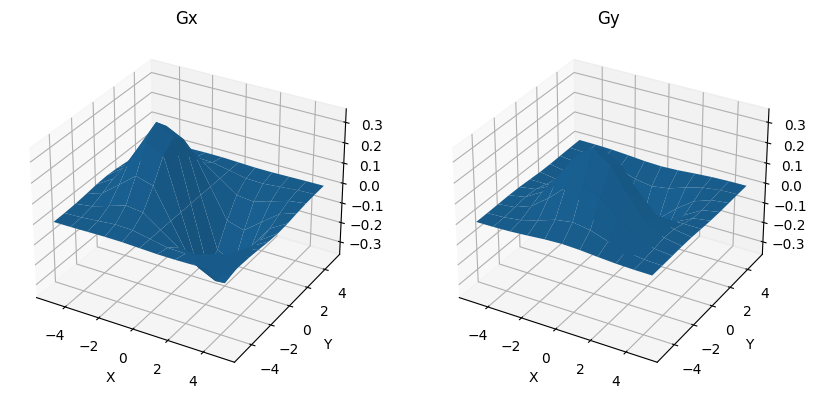

In [36]:
# Run this cell
# Plot gx and gy
wsize = 5
Y,X = np.mgrid[-wsize:wsize+1,-wsize:wsize+1]
Gx, Gy = gauss_derivative_kernels(wsize)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Gx)
ax.set_title("Gx")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, Gy)
ax.set_title("Gy")
ax.set_xlabel("X")
ax.set_ylabel("Y");

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Complete the function below to compute $I_x$ and $I_y$.**

Tips:
- Use `scipy.signal.convolve` to apply the kernels.
- Make sure the target image has the **same** size as the original image.
</div>

In [ ]:
from scipy import signal
signal.convolve?

In [ ]:
# TODO complete this function
def gauss_derivatives(im: np.array, size: int) -> Tuple[np.array, np.array]:
    """
    Returns x and y gaussian derivatives for a given image.
    
    Parameters
    ----------
    im: np.array of shape (rows, cols)
        Input image
    size: int
        Size of the kernels to use
    
    Returns
    -------
    (Ix, Iy): tupe of (np.array, np.array), each of shape (rows, cols)
        Derivatives (x and y) of the image computed using Gaussian derivatives (with kernel of size `size`).
    """
    gx,gy = gauss_derivative_kernels(size)

    imx = np.zeros_like(im)  # FIXME
    imy = np.zeros_like(im)  # FIXME

    return imx,imy

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Load some bubble images and show their derivatives.**

Tips:
- Make sure you compute derivatives on the grayscale image.
- A filter of size $3$ will be used lated.
</div>

In [ ]:
# Some Jupyter magic to help you
# This creates a SORTED list of files to process.
bubble_files = !ls $PATH_TO_RESOURCES/bubbles_200dpi/b*.png | sort
bubble_files[:3]

In [ ]:
# load all the bubbles
bubbles = [cv2.imread(ff) for ff in bubble_files]
# list of bubbles (np.array) in grayscale
bubbles_gray = [cv2.cvtColor(bb, cv2.COLOR_BGR2GRAY) for bb in bubbles]

In [ ]:
# (just run this cell)
# Display some bubbles and their derivatives

# Let us save time
def imbgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

num_bb = 5
plt.figure(figsize=(8,10))
for bb_id in range(num_bb):
    bb = bubbles[bb_id]
    bb_gray = bubbles_gray[bb_id]
    bb_x, bb_y = gauss_derivatives(bb_gray, 3)
    plt.subplot(num_bb,3,1+3*bb_id)
    plt.imshow(imbgr2rgb(bb))
    plt.axis("off")
    plt.title("$I$: bb_%d" % bb_id)
    plt.subplot(num_bb,3,2+3*bb_id)
    plt.imshow(bb_x)
    plt.colorbar(shrink=0.5)
    plt.axis("off")
    plt.title("$I_x$")
    plt.subplot(num_bb,3,3+3*bb_id)
    plt.imshow(bb_y)
    plt.colorbar(shrink=0.75)
    plt.axis("off")
    plt.title("$I_y$")

#### 1.2.2 Harris response
We can now compute the Harris response of an image.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute and show the Harris response for some bubbles.**

Tips:
- Make sure you compute derivatives on the grayscale image.
- A filter of size $3$ is appropriate to compute the derivatives.
- A size of $3$ (the "opening parameter" ie the size of the area we average the value on) is also appropriate for the Gaussian filter used to perform the weighted sum.
    
Expected result:
![](img/harris_resp.png)
    
</div>

In [ ]:
# TODO complete this function
def compute_harris_response(image: np.array) -> np.array:  
    """
    Returns the Harris cornerness response of a given image.
    
    Parameters
    ----------
    im: np.array of shape (rows, cols)
        Input image
    
    Returns
    -------
    response: np.array of shape (rows, cols) and dtype np.float32
        Harris cornerness response image.
    """
    DERIVATIVE_KERNEL_SIZE = 1  # FIXME try different values here
    OPENING_SIZE = 1  # FIXME try different values here

    #derivatives
    imx,imy = gauss_derivatives(image, DERIVATIVE_KERNEL_SIZE)

    #kernel for weighted sum
    gauss = gauss_kernel(OPENING_SIZE) # opening param

    #compute components of the structure tensor
    Wxx = np.zeros_like(image)  # FIXME
    Wxy = np.zeros_like(image)  # FIXME
    Wyy = np.zeros_like(image)  # FIXME

    #determinant and trace
    Wdet = np.zeros_like(image)  # FIXME
    Wtr = np.zeros_like(image)  # FIXME

    # return Wdet - k * Wtr**2 # k is hard to tune
    # return Wdet / Wtr # we would need to filter NaNs
    return Wdet / (Wtr + 1)  # 1 seems to be a reasonable value for epsilon

In [ ]:
# display some bubbles and their Harris response, showing the scale of values
num_bb = 5
plt.figure(figsize=(12,10))
for bb_id in range(num_bb):
    bb = bubbles[bb_id]
    bb_gray = bubbles_gray[bb_id]
    bb_x, bb_y = gauss_derivatives(bb_gray, 4)
    bb_h = compute_harris_response(bb_gray)
    plt.subplot(num_bb,4,1+4*bb_id)
    plt.imshow(imbgr2rgb(bb))
    plt.axis("off")
    plt.title("$I$: bb_%d" % bb_id)
    plt.subplot(num_bb,4,2+4*bb_id)
    plt.imshow(bb_x)
    plt.colorbar(shrink=0.5)
    plt.axis("off")
    plt.title("$I_x$")
    plt.subplot(num_bb,4,3+4*bb_id)
    plt.imshow(bb_y)
    plt.colorbar(shrink=0.75)
    plt.axis("off")
    plt.title("$I_y$")
    plt.subplot(num_bb,4,4+4*bb_id)
    plt.imshow(bb_h)
    plt.colorbar(shrink=0.75)
    plt.axis("off")
    plt.title("Harris resp.")

## 1.3 Identify corners among the maximas
Now we have computed the "cornerness map" of an image, we have to select the best corner candidates.
The full process for selecting keypoints (ie coordinates of corners) can be decomposed in:
1. compute the Harris corner response map;
2. create a mask to select best keypoints and reject the ones which are too close from the border of the image **or of the bubble** (more details below);
3. perform a non-maximal suppression (ignore elements which are not local maximas);
4. sort the candidates based on their response value.

The masking step is a bit special in our case because our bubbles have an artificial boundary inside the image which can cause keypoints to be detected.
We want to reject keypoints which are too close from the bubble boundary to avoid this.
To save you time, we provide you with a simple function `bubble2maskeroded` which takes a bubble and returns a mask which removes the border of the bubble.

In [ ]:
# RUN ME
# mathematical morphology magic: this returns an eroded (shrunk) mask
def bubble2maskeroded(img_gray: np.array, border: int=10) -> np.array:
    """
    Returns the eroded mask of a given image, to remove pixels which are close to the border.
    
    Parameters
    ----------
    im: np.array of shape (rows, cols)
        Input image
    
    Returns
    -------
    mask: np.array of shape (rows, cols) and dtype bool
        Image mask.
    """
    if img_gray.ndim > 2:
        raise ValueError(
            """bubble2maskeroded: img_gray must be a grayscale image.
            The image you passed has %d dimensions instead of 2.
            Try to convert it to grayscale before passing it to bubble2maskeroded.
            """ % (img_gray.ndim, ))
    mask = img_gray > 0
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (border*2,border*2))
    # new: added a little closing below because some bubbles have some black pixels inside
    mask_er = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3,3)))
    mask_er = cv2.erode(mask.astype(np.uint8), 
                        kernel, 
                        borderType=cv2.BORDER_CONSTANT, 
                        borderValue=0)
    return mask_er > 0

In [ ]:
# RUN ME
# bubble2maskeroded demo
bb_id = 5
plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(bubbles_gray[bb_id], cmap='gray')
plt.axis('on'); plt.title("Bubble");
plt.subplot(142)
plt.imshow(bubbles_gray[bb_id] > 0)
plt.axis('on'); plt.title("Mask");
plt.subplot(143)
plt.imshow(bubble2maskeroded(bubbles_gray[bb_id]))
plt.axis('on'); plt.title("Eroded mask");
plt.subplot(144)
plt.imshow((bubbles_gray[bb_id] > 0) & np.logical_not(bubble2maskeroded(bubbles_gray[bb_id])))
plt.axis('on'); plt.title("Removed border");

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Complete the function below to build a complete Harris corner detector.**

Tips:
- Prepare the debug visualization first to check intermediate results progressively.
- Check the mask being created in particular.
- Check the documentation of `np.nonzero` and try it separately.
- Use `np.argsort` to sort values.
</div>

In [ ]:
# TODO complete this function
def detect_harris_points(image_gray: np.array, max_keypoints: int=30, 
                         min_distance: int=25, threshold: float=0.5) -> np.array:
    """
    Detects and returns a sorted list of coordinates for each corner keypoint detected in an image.
    
    Parameters
    ----------
    image_gray: np.array
        Input image
    max_keypoints: int, default=30
        Number of keypoints to return, at most (we may have less keypoints)
    min_distance: int, default=25
        Minimum distance between two keypoints
    threshold: float, default=0.1
        For each keypoint k_i, we ensure that its response h_i will verify
        $h_i > min(response) + threshold * (max(reponse) - min(response))$
    
    Returns
    -------
    corner_coord: np.array of shape (N, 2) and dtype int
        Array of corner keypoint 2D coordinates, with N <= max_keypoints
    """
    # 1. Compute Harris corner response
    harris_resp = compute_harris_response(image_gray)
    
    # 2. Filtering
    # 2.0 Mask init: all our filtering is performed using a mask
    detect_mask = np.ones(harris_resp.shape, dtype=bool)
    # 2.1 Background and border removal
    detect_mask &= bubble2maskeroded(image_gray, border=min_distance)
    # 2.2 Response threshold
    detect_mask &= True  # FIXME <------------------------  # remove low response elements
    # 2.3 Non-maximal suppression
    # dil is an image where each local maxima value is propagated to its neighborhood (display it!)
    dil = cv2.dilate(harris_resp, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (min_distance, min_distance)))
    # we want to keep only elements which are local maximas in their neighborhood
    detect_mask &= True  # FIXME <------------ # keep only local maximas by comparing dil and harris_resp
               
    # 3. Select, sort and filter candidates
    # get coordinates of candidates
    candidates_coords = np.transpose(detect_mask.nonzero())
    # ...and their values
    candidate_values = harris_resp[detect_mask]
    # sort candidates
    sorted_indices = None # FIXME <----------------------
    # keep only the bests
    best_corners_coordinates = candidates_coords  # FIXME <-----------------------

    return best_corners_coordinates

In [ ]:
# (just run this cell)
# Display some bubbles and the detected keypoints
num_bb = 6
min_distance=25
plt.figure(figsize=(8,16))
for bb_id in range(num_bb):
    bb = bubbles[bb_id]
    bb_gray = bubbles_gray[bb_id]
    bb_h = compute_harris_response(bb_gray)
    filtered_coords = detect_harris_points(bb_gray, 
                                        min_distance=min_distance)
    
    plt.subplot(num_bb,3,1+3*bb_id)
    plt.imshow(imbgr2rgb(bb))
    plt.axis("off")
    plt.title("$I$: bb_%d" % bb_id)
    
    plt.subplot(num_bb,3,2+3*bb_id)
    plt.imshow(bb_h)
    plt.axis("off")
    plt.title("Harris resp.")

    plt.subplot(num_bb,3,3+3*bb_id)
    plt.imshow(bb_gray, cmap='gray')
    plt.plot(filtered_coords[:,1], filtered_coords[:,0], 'x', c='r')
    plt.axis("off")
    plt.title("Corners")

## 2. Description of the area around keypoints
This step is actually quite simple here: we will simply store the **raw BGR pixel values** around a given keypoint, and store them as a flat vector.
This is the simplest descriptor we could use.
This will let us reuse the image comparison technique we saw during the session 1 in the next part.

We will extract small patches as in the following example:
![](img/descriptors.png)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Complete the function below to compute a list of descriptors centered around each keypoint.**

Tips:
- Check the boundaries of the image (just in case some keypoints are extracted too close from the border).
- Check the size of the descriptors to avoid generating descriptors we uneven size.
- Display some descriptors for a given bubble.
</div>

In [ ]:
# TODO complete the function below
def compute_descriptors(image_color, filtered_coords, wid=24):
    """ 
    For each point return pixel values around the point
    using a neighbourhood of width 2*wid+1.

    Discard any patch which to not have a shape of (2*wid+1, 2*wid+1, 3).

    return a list of descriptors (list of np.array).
    """
    desc = []
    for coords in filtered_coords:
        pass  # FIXME
    return desc

In [ ]:
# Here is some display to check the results
bb_id = 3
num_descr = 5
patch_half_size = 12
kpts = detect_harris_points(bubbles_gray[bb_id], min_distance=patch_half_size+1)
desc = compute_descriptors(bubbles[bb_id], kpts, wid=patch_half_size)
plt.figure(figsize=(10,4))
plt.subplot(1,num_descr+1,1)
plt.imshow(bubbles_gray[bb_id], cmap='gray')
plt.plot(kpts[:,1], kpts[:,0], 'x', c='r')
plt.axis("off")
plt.title("Corners")
for ii in range(min(num_descr, len(desc))):
    plt.subplot(1,num_descr+1,2+ii)
    dside = int(np.sqrt(desc[ii].shape[0]/3)) # recover the patch size
    plt.imshow(cv2.cvtColor(desc[ii].reshape((dside, dside, 3)), cv2.COLOR_BGR2RGB))
    plt.plot([dside//2], [dside//2], '*', c='r')
#     plt.axis('off')
    plt.title("Descr. %d" % ii)

## 3. Precompute the keypoints and their descriptors for all the bubbles
This will be useful for the next part, to accelerate the computation of the matching.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Pre-compute all the keypoints and descriptors for all bubbles.**

Tips:
- Extract descriptors from regions of approximatively 25 per 25 pixels, separated at least by 10 pixels.
- Others values may produce different results: you may want to come back here at the end of the session to try different extraction strategies.
</div>

In [ ]:
# TODO precompute keypoints and descriptors for all bubbles using `bubbles` and `bubbles_gray`
patch_half_size = 1  # FIXME
# list of list of keypoints for all bubbles: keypoints[i][j]: (np.array) keypoint j for bubbles_gray[i]
keypoints = []
# list of list of descriptors for all bubbles: descriptors[i][j]: (np.array) desc j for bubbles[i]
descriptors = []
# FIXME
print(len(keypoints), len(descriptors))

In [ ]:
# Sanity check: do we have bubbles without keypoints?
for ii, ki in enumerate(keypoints):
    if len(ki) == 0:
        plt.figure()
        plt.imshow(bubbles_gray[ii], cmap='gray')
        plt.axis('off')
        plt.title("b%03d.png" % (ii+1))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Save the pre-computed keypoints and descriptors: we will use then in the next part.**

Tips:
- Save them somewhere on the network to save RAM (if working in EPITA's computers).
- Use `np.savez_compressed` or any similar function to save objects.
</div>

In [ ]:
# save keypoints and descriptors somewhere
# TODO adapt this code to your actual parameters and variable names
# NOTE: we want to keep lists are we have unequal numbers of keypoints and descriptors for each bubble
# FIXME (Joseph): using joblib would be much better here

np.savez_compressed("results/kpts_descr_harris_25pxcolor_mdist10.npz", 
                    descriptors=descriptors,
                    keypoints=keypoints)
# Check output
!ls -lh results/kpts_descr_harris_25pxcolor_mdist10.npz

# Job done!
Now you're ready to move on to the next stage: [Match keypoints and solve *Twin it!*](practice_02-02_twinit-part2-matching.ipynb).